# A2 Report: Deep Squat Movement Assessment

**Team Members:** Reem, Rasa, Amol (Scrum master for this week), Kalle

---

## 1. Problem Statement

The goal is to build an ML model that automatically tests Deep Squat movement quality. The input has 40 preprocessed features from 3D skeleton data taken by a Kinect camera. The output is an AimoScore ranging from 0 to 1.0, where higher scores indicate better movement quality.

## 2. Dataset Overview

The dataset contains about 2000 deep squat assessments split into 80% training and 20% test sets.

In [7]:
import pandas as pd
import numpy as np
import os

# Load dataset
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(REPO_ROOT, "Datasets_all")

# Load original dataset (with duplicates)
train_df = pd.read_csv(os.path.join(DATA_DIR, "A2_dataset_80.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "A2_dataset_20.csv"))

print("Dataset")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total features: {len(train_df.columns) - 2}")  # -2 for AimoScore and EstimatedScore
print(f"\nFeature types:")
print(f"  - FMS Angle deviations (body joints): 13 features")
print(f"  - NASM deviations (mvmt patterns): 25 features")
print(f"  - Time deviations (phases of squat): 2 features")
print(f"\nTarget: AimoScore (range: {train_df['AimoScore'].min():.2f} - {train_df['AimoScore'].max():.2f})")

Dataset
Training samples: 1675
Test samples: 419
Total features: 40

Feature types:
  - FMS Angle deviations (body joints): 13 features
  - NASM deviations (mvmt patterns): 25 features
  - Time deviations (phases of squat): 2 features

Target: AimoScore (range: 0.01 - 0.99)


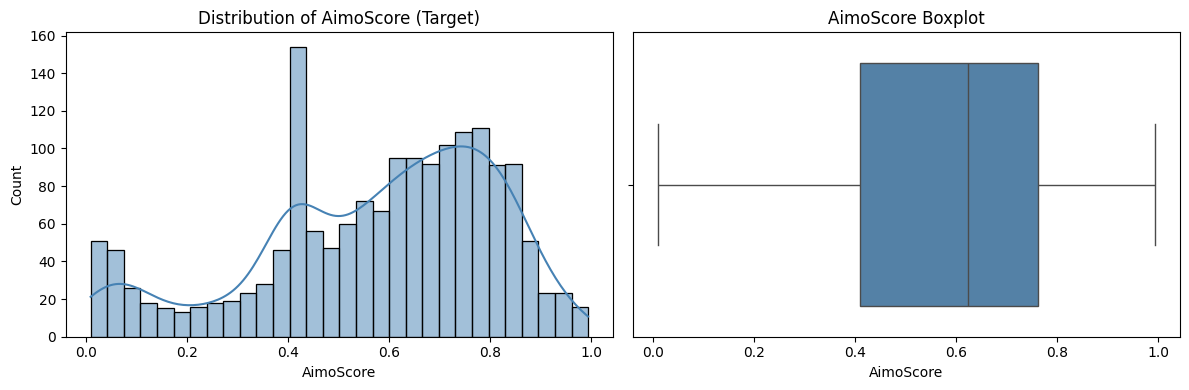

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Target distribution
sns.histplot(train_df['AimoScore'], bins=30, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of AimoScore (Target)')
axes[0].set_xlabel('AimoScore')

# Box plot
sns.boxplot(x=train_df['AimoScore'], ax=axes[1], color='steelblue')
axes[1].set_title('AimoScore Boxplot')

plt.tight_layout()
plt.show()

## 3. Domain Insights

### 3.1 Duplicate Features

Some FMS and NASM features measure the same angles and so are identical. We find and remove these duplicates during preprocessing to avoid redundancy and multicollinearity issues.

In [9]:
# Check for duplicate features
X = train_df.drop(columns=['AimoScore', 'EstimatedScore'])

# Find duplicate columns
duplicates = X.T.duplicated()
duplicate_cols = X.columns[duplicates].tolist()

print(f"Original features: 40")
print(f"Duplicate features found: {len(duplicate_cols)}")
print(f"Features after removal: {40 - len(duplicate_cols)}")
print(f"\nDuplicate columns removed: {duplicate_cols}")

Original features: 40
Duplicate features found: 5
Features after removal: 35

Duplicate columns removed: ['No_1_NASM_Deviation', 'No_2_NASM_Deviation', 'No_3_NASM_Deviation', 'No_4_NASM_Deviation', 'No_5_NASM_Deviation']


### 3.2 Left-Right Symmetry Constraints

Good squat form should be symmetric on the left and right. We enforce this by averaging left-right feature pairs during training.

Symmetric FMS pairs: (4,6), (5,7), (8,11), (9,12), (10,13)  
Symmetric NASM pairs: (14,15), (17,18), (21,22), (24,25), (26,27), (28,29), (31,32)

### 3.3 Expert-Defined Feature Weights

Not all features are equally important for scoring. Domain experts assign weights based on importance.

## 4. ML Pipeline Architecture

We built three sklearn transformers to encode domain knowledge: CorrelationFilter removes very correlated features, SymmetryConstraintTransformer averages left-right pairs, and FeatureWeightMultiplier applies expert weights.

For outlier removal approach: IQR method to remove samples outside 1.5×IQR, then Cook's Distance to find influential points with threshold 4/n.

## 5. Model Variants and Evaluation

We tested 8 model variants using 5-fold cross validation. Each variant combines different preprocessing steps and regularization techniques to find the best performing configuration.

In [10]:
# Model variants comparison
variants_data = {
    'Variant': [
        'baseline',
        'corr_filter',
        'feature_selection_lasso',
        'combined_poly2_ridge',
        'symmetry_constraint',
        'weighted_features',
        'combined_final',
        'outlier_iqr_plus_cooks'
    ],
    'Technique': [
        'StandardScaler + LinearRegression',
        'CorrelationFilter(0.99) + LR',
        'LassoCV feature selection + LR',
        'PolynomialFeatures(2) + Ridge',
        'SymmetryConstraint + LR',
        'FeatureWeights + LR',
        'CorrFilter + Symmetry + Weights + Ridge',
        'IQR + Cooks Distance outlier removal + LR'
    ],
    'CV R² (approx)': [
        '~0.52',
        '~0.52',
        '~0.50',
        '~0.53',
        '~0.54',
        '~0.55',
        '~0.58',
        '~0.59'
    ]
}

variants_df = pd.DataFrame(variants_data)
print(variants_df.to_string(index=False))

                Variant                                 Technique CV R² (approx)
               baseline         StandardScaler + LinearRegression          ~0.52
            corr_filter              CorrelationFilter(0.99) + LR          ~0.52
feature_selection_lasso            LassoCV feature selection + LR          ~0.50
   combined_poly2_ridge             PolynomialFeatures(2) + Ridge          ~0.53
    symmetry_constraint                   SymmetryConstraint + LR          ~0.54
      weighted_features                       FeatureWeights + LR          ~0.55
         combined_final   CorrFilter + Symmetry + Weights + Ridge          ~0.58
 outlier_iqr_plus_cooks IQR + Cooks Distance outlier removal + LR          ~0.59


We evaluate each variant using RMSE, MAE, R², and Pearson correlation. The outlier removal variant achieved the best cross-validation performance and was selected as our champion model.

## 6. Champion Model Results

The champion model uses IQR and Cook's Distance outlier removal followed by standard scaling and linear regression. Below we load the saved model and display its performance metrics.

In [11]:
import pickle

# Load champion model
model_path = "models/champion_model_final.pkl"
with open(model_path, "rb") as f:
    artifact = pickle.load(f)

print("Champion model performance")
print(f"\nFeatures used: {len(artifact['feature_columns'])}")
print(f"\nTest Set Metrics:")
for metric, value in artifact['test_metrics'].items():
    print(f"  {metric.upper()}: {value:.4f}")

print(f"\nCross-Validation Metrics:")
for metric, value in artifact['train_metrics'].items():
    print(f"  {metric}: {value:.4f}")

Champion model performance

Features used: 35

Test Set Metrics:
  RMSE: 0.1493
  MAE: 0.1140
  R2: 0.5891
  CORRELATION: 0.7676

Cross-Validation Metrics:
  cv_rmse_mean: 0.1568
  cv_r2_mean: 0.5590
  cv_corr_mean: 0.7504


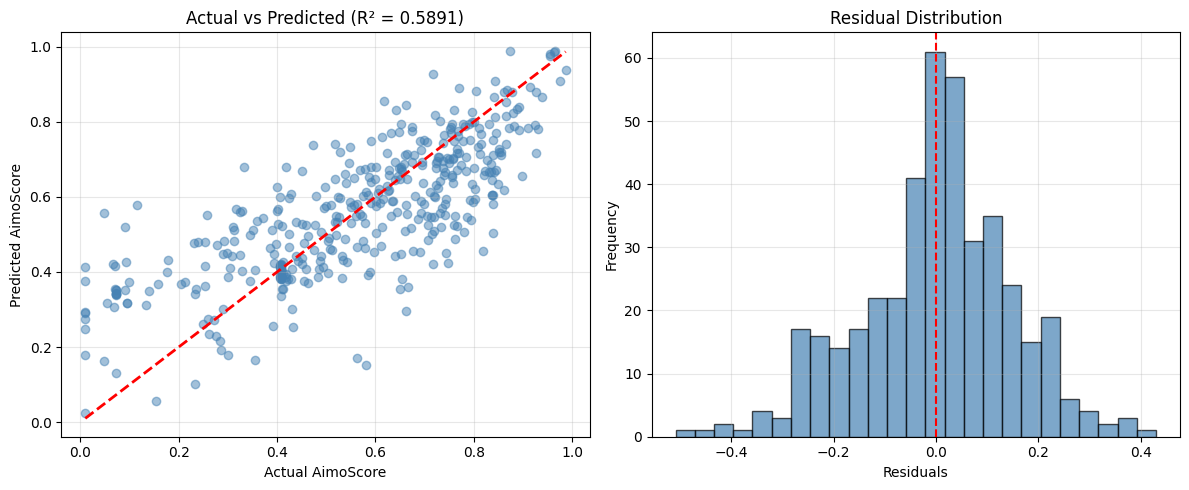

In [12]:
# Visualise predictions on test set
from sklearn.metrics import r2_score

# Prepare test data - use columns from the trained model
kept_cols = artifact['feature_columns']
# Filter to only columns that exist in test_df
available_cols = [c for c in kept_cols if c in test_df.columns]
X_test = test_df[available_cols].copy()
y_test = test_df['AimoScore']

# Predict
model = artifact['model']
y_pred = model.predict(X_test)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Actual vs predicted
axes[0].scatter(y_test, y_pred, alpha=0.5, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual AimoScore')
axes[0].set_ylabel('Predicted AimoScore')
axes[0].set_title(f'Actual vs Predicted (R² = {r2_score(y_test, y_pred):.4f})')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred
axes[1].hist(residuals, bins=25, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Deployment

The model is deployed as a Gradio web application on HuggingFace Spaces. Users can input feature values with sliders in three tabs (Angle, NASM, Time deviations) and get a predicted score with interpretation. The app also has a "Load Random Example" button to test with real random data from the dataset.

Deployment URL: https://huggingface.co/spaces/Bachstelze/github_sync

## 8. DevOps/MLOps Process

We use GitHub Actions for continuous deployment. When code is pushed to the main branch, the workflow automatically syncs the repository to HuggingFace Spaces. The file `.github/workflows/push_to_hf_space.yml` handles authentication using the HF_TOKEN secret and force pushes to the HuggingFace space repository.

## 9. Conclusion

The champion model gets R² of about 0.59, explaining 59% of the variance in expert scores. The remaining variance probably comes from subjective expert judgment and factors not captured by the 40 input features. Another reason could be that different body structures often have different natural forms that the body summumbs to, amongst other domain reasons. 